In [89]:
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combining Results

In [75]:
BASE = Path("Dissertation") / "3b) Single LLM Prompt Engineering for Loan Approval Prediction" / "Gemini 2.5 Flash Lite"
EXPERIMENTS = [
    "baseline_no_race.csv",
    "baseline_with_race.csv",
    "justify_after_with_race.csv",
    "justify_before_no_race.csv",
    "justify_before_with_race.csv",
    "CoT_no_race.csv",
    "CoT_with_race.csv",
    "CoT_Engineered.csv"
]
INPUT_RATE  = 0.10 / 1_000_000
OUTPUT_RATE = 0.40 / 1_000_000

FEATURE_COLS = [
    "income","loan_amount","loan_to_value_ratio","property_value",
    "debt_to_income_ratio","applicant_age"
]

for exp in EXPERIMENTS:
    files = [BASE / f"Run {i}" / exp for i in [1,2,3,4,5,6]]
    if not all(f.exists() for f in files):
        print(f"Skipping {exp}: not found in all runs.")
        continue

    dfs = [pd.read_csv(f) for f in files]

    approval_by_race = [df.groupby("derived_race")["llm_decision"].mean() for df in dfs]
    approval_matrix = pd.DataFrame(approval_by_race)
    mean_std_summary = approval_matrix.agg(['mean','std'])
    mean_black = mean_std_summary.get("Black or African American", {}).get("mean", np.nan)
    std_black  = mean_std_summary.get("Black or African American", {}).get("std",  np.nan)
    mean_white = mean_std_summary.get("White", {}).get("mean", np.nan)
    std_white  = mean_std_summary.get("White", {}).get("std",  np.nan)

    total_cost = 0.0
    for df in dfs:
        input_tokens  = df.get("prompt_tokens",  pd.Series([], dtype=float)).fillna(0)
        output_tokens = df.get("output_tokens", pd.Series([], dtype=float)).fillna(0)
        total_cost += input_tokens.sum()*INPUT_RATE + output_tokens.sum()*OUTPUT_RATE

    combined_rows = []
    n_rows = len(dfs[0])

    for idx in range(n_rows):
        row_runs = [df.iloc[idx] for df in dfs]
        base_row = row_runs[0]

        real_decision = base_row.get('action_taken')
        
        # handle NaN safely
        decisions = [
            int(r["llm_decision"]) if pd.notna(r.get("llm_decision")) else 0
            for r in row_runs
        ]
        maj_dec = 1 if sum(decisions) >= 4 else 0


        try:
            just = next(eval(str(r.get("llm_json")))['justification']
                        for r in row_runs if int(r.get("llm_decision",0)) == maj_dec)
        except Exception:
            just = None

        elapsed_list = [r.get("elapsed_seconds", None) for r in row_runs]
        elapsed_clean = [e for e in elapsed_list if e not in (None, 0)]
        mean_elapsed = float(np.mean(elapsed_clean)) if elapsed_clean else None

        mean_prompt = float(np.nanmean([r.get("prompt_tokens", np.nan) for r in row_runs]))
        mean_output = float(np.nanmean([r.get("output_tokens", np.nan) for r in row_runs]))
        mean_total  = float(np.nanmean([r.get("total_tokens",  np.nan) for r in row_runs]))

        features = {c: base_row.get(c, np.nan) for c in FEATURE_COLS}

        combined_rows.append({
            "derived_race": base_row.get("derived_race"),
            "action_taken": real_decision,
            "LLM_decision": maj_dec,
            "justification": just,
            "mean_elapsed_seconds": mean_elapsed,
            "mean_prompt_tokens": mean_prompt,
            "mean_output_tokens": mean_output,
            "mean_total_tokens": mean_total,
            "run_cost_usd": total_cost,
            **features,
        })

    final_df = pd.DataFrame(combined_rows)
    final_df['mean_approval_rate_black'] = mean_black
    final_df['stdv_approval_rate_black'] = std_black
    final_df['mean_approval_rate_white'] = mean_white
    final_df['stdv_approval_rate_white'] = std_white
    final_df['correlation_llm_lender'] = final_df['LLM_decision'].corr(final_df['action_taken'])

    out_path = BASE / f"Gemini_Combined_{exp}"
    #final_df.to_excel(str(out_path).replace('.csv', '.xlsx'), index=False)
    final_df.to_csv(str(out_path).replace('.csv', '.csv'), index=False)

    print(f"Saved {out_path}")

print("All experiment runs processed!")

Saved Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\Gemini 2.5 Flash Lite\Gemini_Combined_baseline_no_race.csv
Saved Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\Gemini 2.5 Flash Lite\Gemini_Combined_baseline_with_race.csv
Saved Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\Gemini 2.5 Flash Lite\Gemini_Combined_justify_after_with_race.csv
Saved Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\Gemini 2.5 Flash Lite\Gemini_Combined_justify_before_no_race.csv
Saved Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\Gemini 2.5 Flash Lite\Gemini_Combined_justify_before_with_race.csv
Saved Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\Gemini 2.5 Flash Lite\Gemini_Combined_CoT_no_race.csv
Saved Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\Gemini 2.5 Flash Lite\Gemini_Combined_CoT_with_race.cs

In [77]:
BASE = Path("Dissertation") / "3b) Single LLM Prompt Engineering for Loan Approval Prediction" / "Gemini 2.5 Flash Lite"/ "Combined Results"
SUMMARY_FILES = list(BASE.glob("Gemini_Combined_*.csv"))
rates_dict = {}
for file in SUMMARY_FILES:
    exp = file.name.replace("Gemini_Combined_", "").replace(".csv", "")
    df = pd.read_csv(file)
    rates_dict[exp] = {
        "Approval Rate (Black)": df['mean_approval_rate_black'].iloc[0],
        "Approval Rate (White)": df['mean_approval_rate_white'].iloc[0],
        "Run's Standard Deviation (Black)": df['stdv_approval_rate_black'].iloc[0],
        "Run's Standard Deviation (White)": df['stdv_approval_rate_white'].iloc[0],
        "Mean Elapsed Time (s)": df['mean_elapsed_seconds'].mean(),
        "Correlation (LLM/Lender)": df['correlation_llm_lender'].iloc[0],
        "Total Cost ($)": df['run_cost_usd'].iloc[0],
    }
rows = []
EXPERIMENT_PAIRS = [
    ("baseline_with_race", "baseline_no_race", "Baseline Prompt"),
    ("justify_after_with_race", "baseline_no_race", "P.E. Reasoning"),
    ("justify_before_with_race", "justify_before_no_race", "P.F. Reasoning"),
    ("CoT_with_race", "CoT_no_race", "CoT"),
    ("CoT_Engineered", "CoT_no_race", "CoT with Fairness"),
]    
for with_race, no_race, name in EXPERIMENT_PAIRS:
    if with_race in rates_dict and no_race in rates_dict:
        mean_no_race = (rates_dict[no_race]["Approval Rate (Black)"] + rates_dict[no_race]["Approval Rate (White)"]) / 2
        abs_bias = abs(rates_dict[with_race]["Approval Rate (Black)"] - mean_no_race) + \
                   abs(rates_dict[with_race]["Approval Rate (White)"] - mean_no_race)
        random_group_disparity = abs(rates_dict[no_race]["Approval Rate (Black)"] - rates_dict[no_race]["Approval Rate (White)"])
        row = {
            "Experiment Condition": name,
            "Approval Rate (Black)": rates_dict[with_race]["Approval Rate (Black)"],
            "Approval Rate (White)": rates_dict[with_race]["Approval Rate (White)"],
            "Demographic Parity": abs(rates_dict[with_race]["Approval Rate (Black)"] - rates_dict[with_race]["Approval Rate (White)"]),
            "Absolute Bias": abs_bias,
            "Run's Standard Deviation (Black)": rates_dict[with_race]["Run's Standard Deviation (Black)"],
            "Run's Standard Deviation (White)": rates_dict[with_race]["Run's Standard Deviation (White)"],
            "Random Group Disparity (No Race)": random_group_disparity,
            "Mean Elapsed Time (s)": rates_dict[with_race]["Mean Elapsed Time (s)"],
            "Correlation (LLM/Lender)": rates_dict[with_race]["Correlation (LLM/Lender)"],
            "Total Cost ($)": rates_dict[with_race]["Total Cost ($)"],
        }
        rows.append(row)
summary_df = pd.DataFrame(rows)
summary_df = summary_df.round(3)
summary_df.to_csv(BASE / "Gemini_Master_Experiment_Summary.csv", index=False)
summary_df.to_excel(BASE / "Gemini_Master_Experiment_Summary.xlsx", index=False)
print(summary_df)

  Experiment Condition  Approval Rate (Black)  Approval Rate (White)  \
0      Baseline Prompt                  0.362                  0.352   
1       P.E. Reasoning                  0.330                  0.375   
2       P.F. Reasoning                  0.183                  0.238   
3                  CoT                  0.295                  0.306   
4    CoT with Fairness                  0.279                  0.267   

   Demographic Parity  Absolute Bias  Run's Standard Deviation (Black)  \
0               0.010          0.175                             0.004   
1               0.045          0.167                             0.013   
2               0.055          0.055                             0.010   
3               0.011          0.062                             0.013   
4               0.012          0.012                             0.010   

   Run's Standard Deviation (White)  Random Group Disparity (No Race)  \
0                             0.004              

# Analysis:

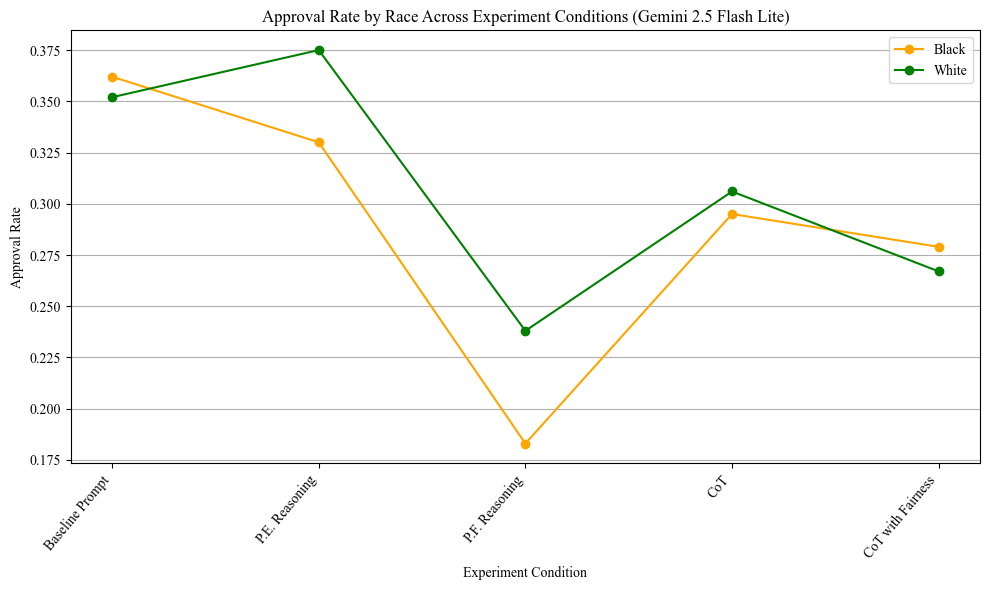

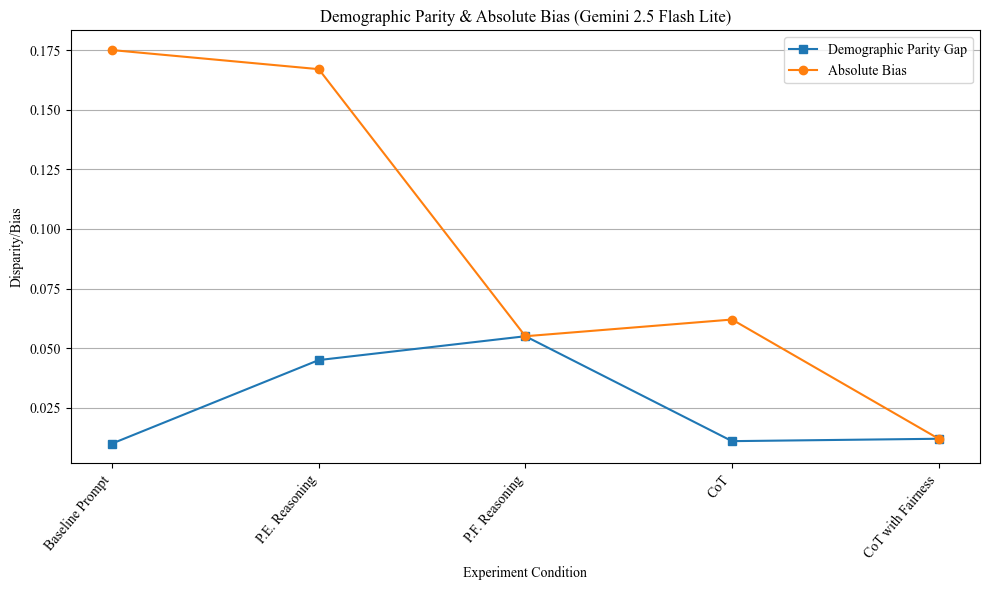

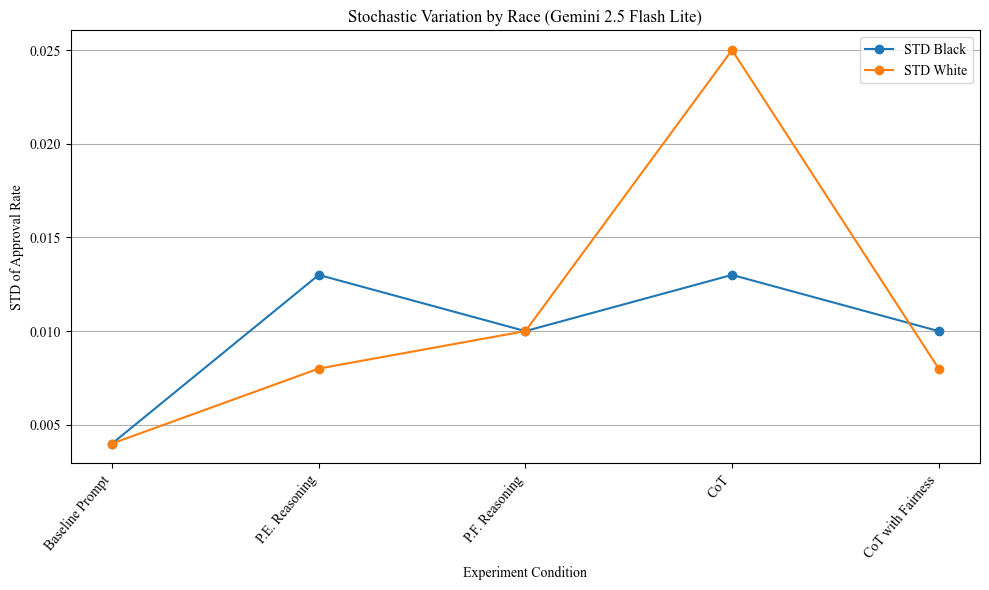

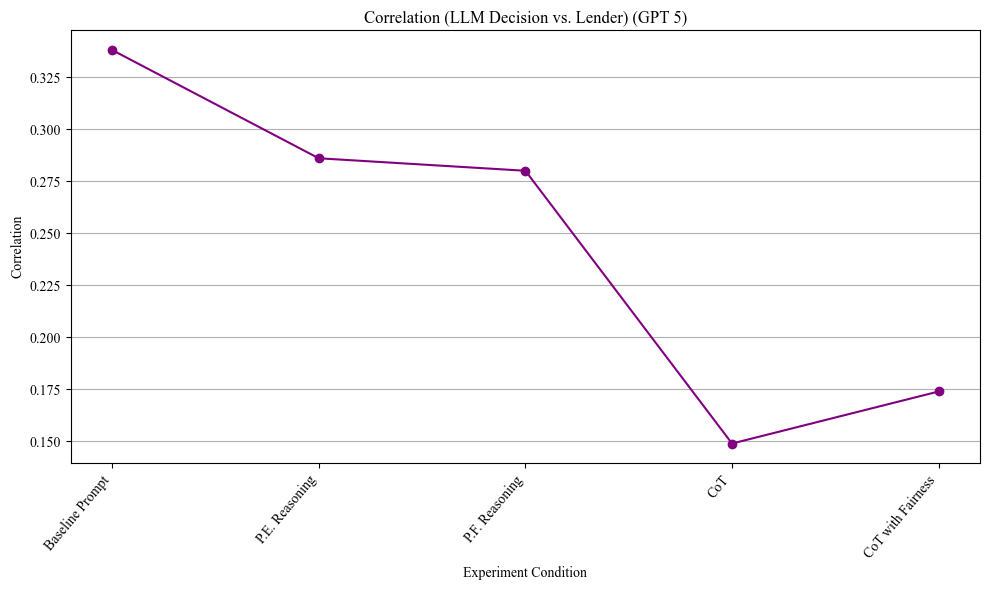

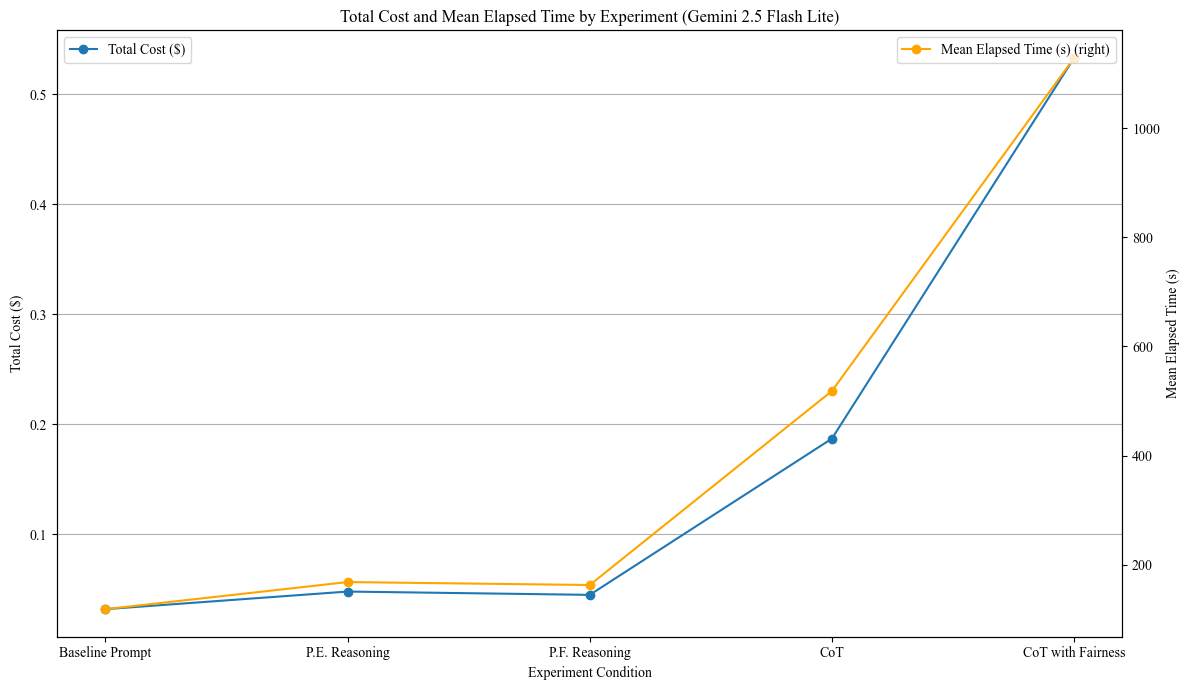

In [71]:
BASE = "Dissertation/3b) Single LLM Prompt Engineering for Loan Approval Prediction/Gemini 2.5 Flash Lite/Combined Results"
df = pd.read_csv(BASE + "/Gemini_Master_Experiment_Summary.csv")
df.set_index("Experiment Condition", inplace=True)
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10,6))
df["Approval Rate (Black)"].plot(marker='o', label="Black", color='orange')
df["Approval Rate (White)"].plot(marker='o', label="White", color='green')
plt.ylabel("Approval Rate")
plt.title("Approval Rate by Race Across Experiment Conditions (Gemini 2.5 Flash Lite)")
plt.xticks(ticks=range(len(df.index)), labels=df.index, rotation=50, ha='right')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
df["Demographic Parity"].plot(marker='s', label="Demographic Parity Gap")
df["Absolute Bias"].plot(marker='o', label="Absolute Bias")
plt.ylabel("Disparity/Bias")
plt.title("Demographic Parity & Absolute Bias (Gemini 2.5 Flash Lite)")
plt.xticks(ticks=range(len(df.index)), labels=df.index, rotation=50, ha='right')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
df["Run's Standard Deviation (Black)"].plot(marker='o', label="STD Black")
df["Run's Standard Deviation (White)"].plot(marker='o', label="STD White")
plt.ylabel("STD of Approval Rate")
plt.title("Stochastic Variation by Race (Gemini 2.5 Flash Lite)")
plt.xticks(ticks=range(len(df.index)), labels=df.index, rotation=50, ha='right')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
df["Correlation (LLM/Lender)"].plot(marker='o', color='purple')
plt.ylabel("Correlation")
plt.title("Correlation (LLM Decision vs. Lender) (GPT 5)")
plt.xticks(ticks=range(len(df.index)), labels=df.index, rotation=50, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 7))
ax1 = df["Total Cost ($)"].plot(marker='o', label="Total Cost ($)")
ax2 = ax1.twinx()
df["Mean Elapsed Time (s)"].plot(marker='o', color='orange', label="Mean Elapsed Time (s) (right)", ax=ax2)
ax1.set_ylabel("Total Cost ($)")
ax2.set_ylabel("Mean Elapsed Time (s)")
plt.title("Total Cost and Mean Elapsed Time by Experiment (Gemini 2.5 Flash Lite)")
plt.xticks(
    ticks=range(len(df.index)), 
    labels=df.index, 
    rotation=55, 
    ha='right',
    fontsize=10,
)
plt.subplots_adjust(bottom=0.33)
ax1.grid(axis='y')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()



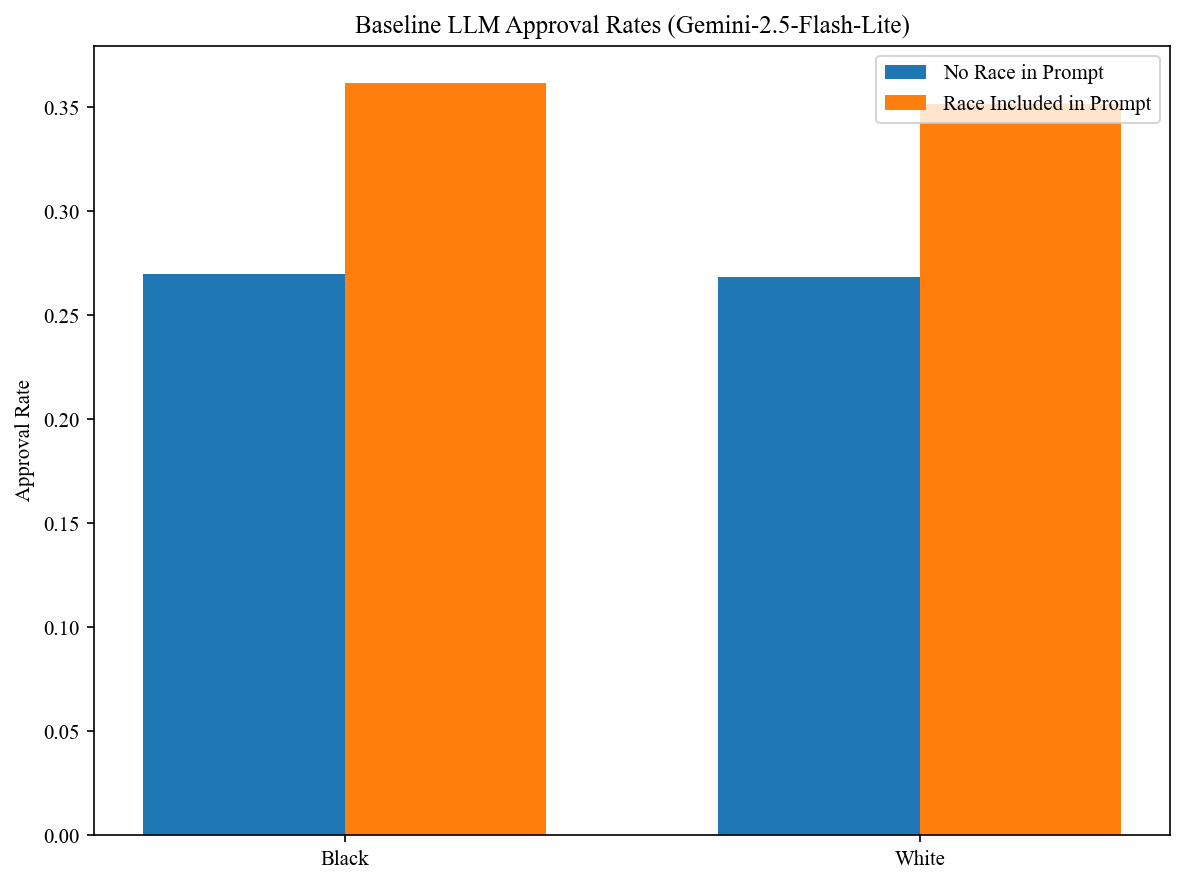

In [101]:
plt.rcParams['font.family'] = 'Times New Roman'
with_black = df_with_race['mean_approval_rate_black'].iloc[0]
with_white = df_with_race['mean_approval_rate_white'].iloc[0]
no_black = df_no_race['mean_approval_rate_black'].iloc[0]
no_white = df_no_race['mean_approval_rate_white'].iloc[0]
labels = ['Black', 'White']
with_race = [with_black, with_white]
no_race = [no_black, no_white]
x = range(len(labels))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
bars1 = ax.bar([i - bar_width/2 for i in x], no_race, bar_width, label='No Race in Prompt')
bars2 = ax.bar([i + bar_width/2 for i in x], with_race, bar_width, label='Race Included in Prompt')
ax.set_ylabel('Approval Rate')
ax.set_title('Baseline LLM Approval Rates (Gemini-2.5-Flash-Lite)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()


# Sub Group Segment Analysis

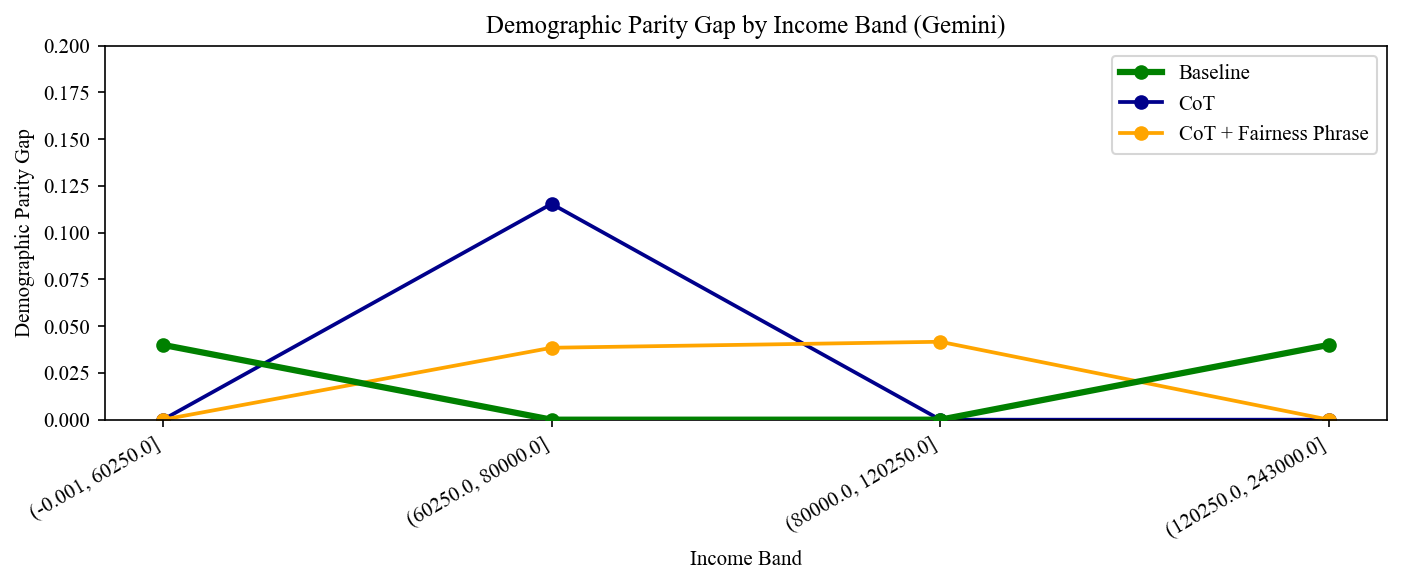

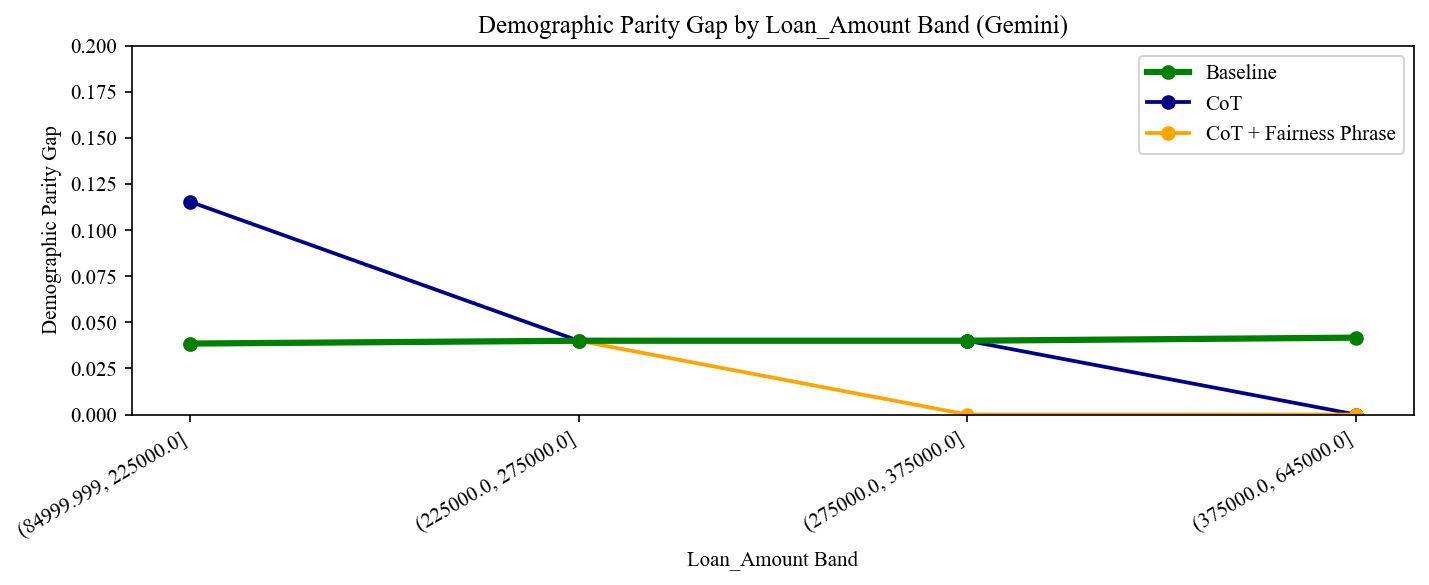

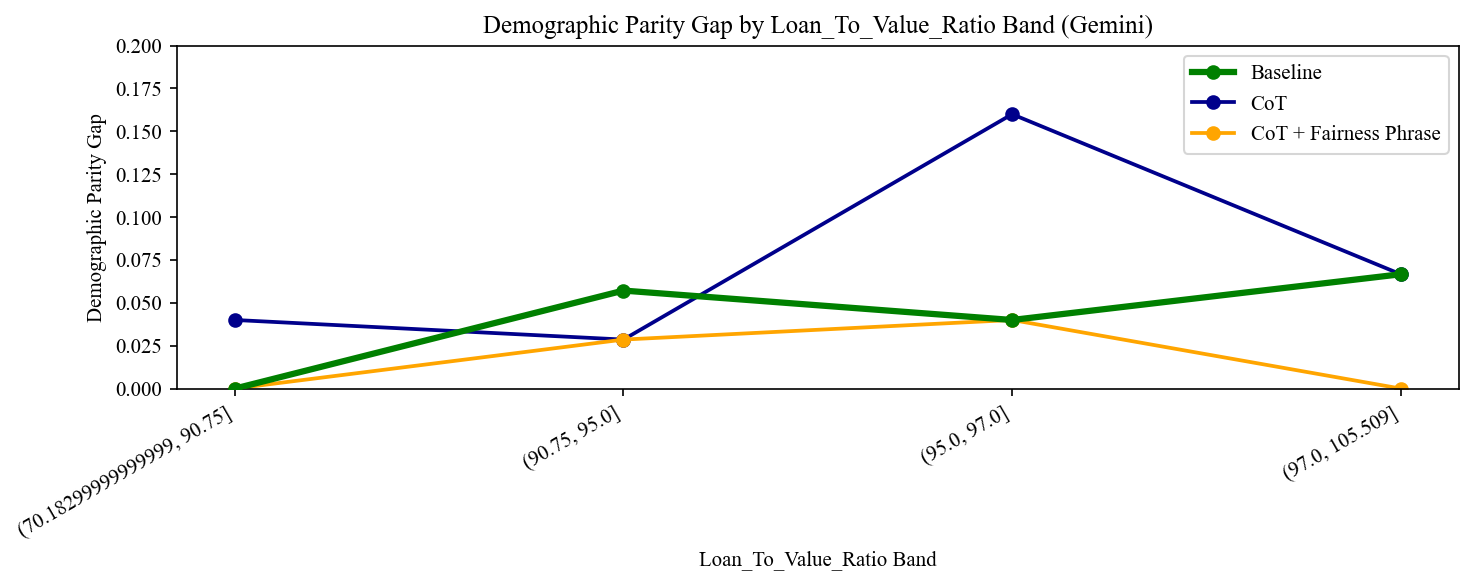

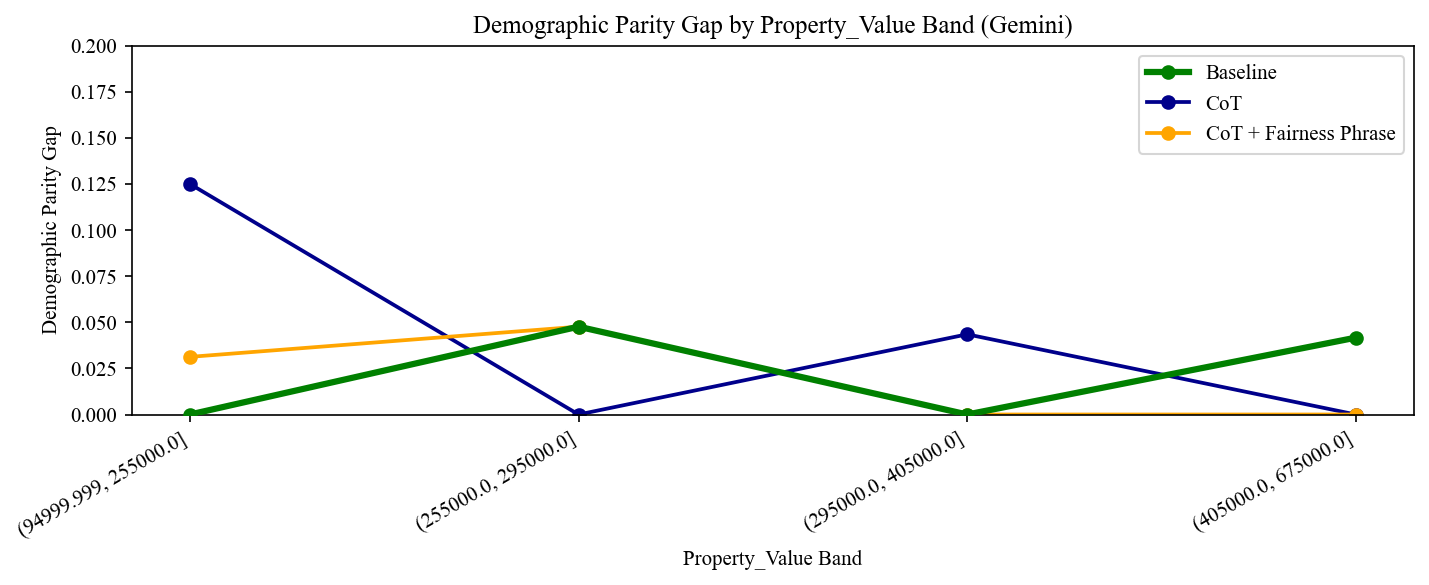

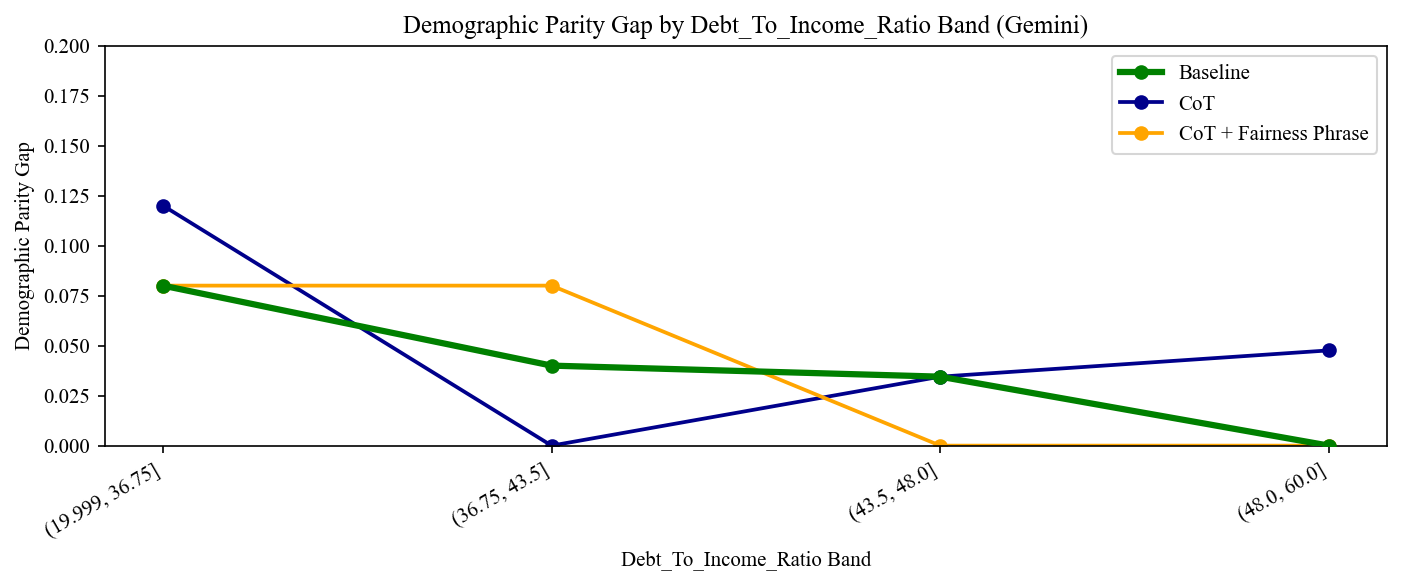

In [85]:

FILES = {
    "Baseline": Path("Dissertation") / "3b) Single LLM Prompt Engineering for Loan Approval Prediction" / "Gemini 2.5 Flash Lite" / "Combined Results" / "Gemini_Combined_baseline_with_race.csv",
    "CoT": Path("Dissertation") / "3b) Single LLM Prompt Engineering for Loan Approval Prediction" / "Gemini 2.5 Flash Lite" / "Combined Results" / "Gemini_Combined_CoT_with_race.csv",
    "CoT + Fairness Phrase": Path("Dissertation") / "3b) Single LLM Prompt Engineering for Loan Approval Prediction" / "Gemini 2.5 Flash Lite" / "Combined Results" / "Gemini_Combined_CoT_Engineered.csv",
}

features = ["income", "loan_amount", "loan_to_value_ratio", "property_value", "debt_to_income_ratio"]
num_bins = 4

all_dp_gaps = {feature: {} for feature in features}
all_band_labels = {}
for run_name, file_path in FILES.items():
    df = pd.read_csv(file_path)

    if "derived_race" not in df.columns or "LLM_decision" not in df.columns:
        continue

    for feature in features:
        if feature not in df.columns:
            continue
        bin_label = f"{feature}_band"
        try:
            df[bin_label] = pd.qcut(df[feature], q=num_bins, duplicates="drop")
        except Exception:
            continue

        grouped = (
            df.groupby([bin_label, "derived_race"], dropna=False, observed=False)["LLM_decision"]
              .agg(Approval_Rate="mean")
              .reset_index()
        )

        bands, dp_gaps = [], []
        for band in grouped[bin_label].unique():
            sub = grouped[grouped[bin_label] == band].dropna(subset=["Approval_Rate"])
            if sub.shape[0] < 2:
                continue
            dp_gap = sub["Approval_Rate"].max() - sub["Approval_Rate"].min()
            bands.append(str(band))
            dp_gaps.append(dp_gap)

        all_dp_gaps[feature][run_name] = dp_gaps
        if feature not in all_band_labels or len(bands) > len(all_band_labels[feature]):
            all_band_labels[feature] = bands
plt.rc('font', family='Times New Roman')
Y_MAX = 0.2  

for feature in features:
    bands = all_band_labels.get(feature, [])
    if not bands:
        continue

    plt.figure(figsize=(10, 4), dpi=150)
    color_cycle = ["green", "darkblue", "orange"]

    for (run_name, color) in zip(FILES.keys(), color_cycle):
        dp_gaps = all_dp_gaps[feature].get(run_name, [])
        if len(dp_gaps) == len(bands):
            lw = 3 if run_name == "Baseline" else 1.8
            z = 10 if run_name == "Baseline" else 1
            plt.plot(bands, dp_gaps, marker='o', linestyle='-', label=run_name, color=color, linewidth=lw, zorder=z)

    plt.title(f"Demographic Parity Gap by {feature.title()} Band (Gemini)")
    plt.ylabel("Demographic Parity Gap")
    plt.xlabel(f"{feature.title()} Band")
    plt.xticks(rotation=30, ha="right")
    plt.ylim(0, Y_MAX)
    plt.legend()
    plt.tight_layout()
    plt.subplots_adjust(left=0.13)
    plt.show()


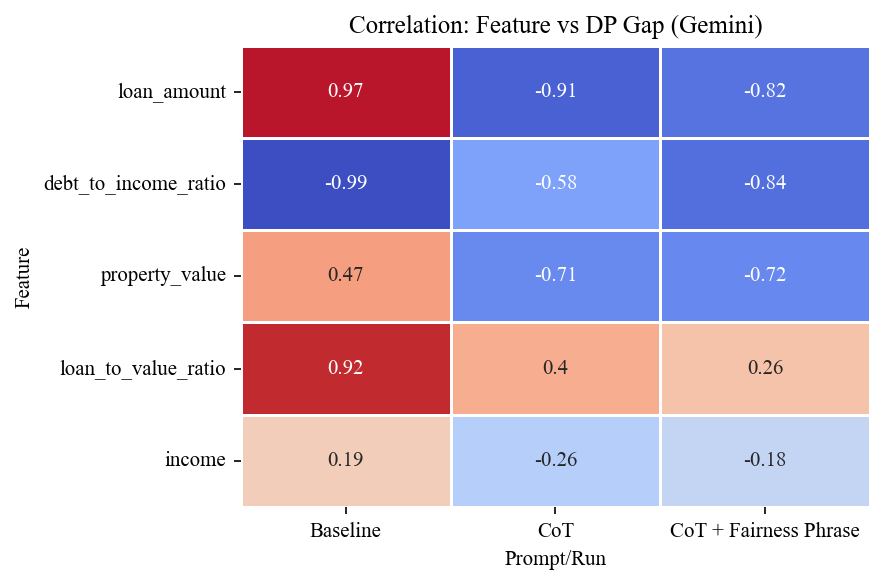

In [93]:
all_correlations = {feature: {} for feature in features}
for run_name, file_path in FILES.items():
    df = pd.read_csv(file_path)
    for feature in features:
        if feature not in df.columns:
            continue
        bin_label = feature + "_band"
        try:
            df[bin_label] = pd.qcut(df[feature], q=num_bins, duplicates='drop')
        except Exception:
            continue

        grouped = (
            df.groupby([bin_label, "derived_race"], dropna=False, observed=False)["LLM_decision"]
              .agg(Approval_Rate="mean")
              .reset_index()
        )

        band_values = []
        dp_gaps = []
        for band in grouped[bin_label].unique():
            sub = grouped[grouped[bin_label] == band]
            sub = sub.dropna(subset=["Approval_Rate"])
            if sub.shape[0] < 2:
                continue
            dp_gap = sub["Approval_Rate"].max() - sub["Approval_Rate"].min()
            if hasattr(band, 'left') and hasattr(band, 'right'):
                band_value = (band.left + band.right) / 2
            else:
                band_value = np.nan
            band_values.append(band_value)
            dp_gaps.append(dp_gap)
        mask = ~np.isnan(band_values)
        if np.sum(mask) >= 2:
            corr = np.corrcoef(np.array(band_values)[mask], np.array(dp_gaps)[mask])[0,1]
            all_correlations[feature][run_name] = corr
        else:
            all_correlations[feature][run_name] = np.nan
corr_matrix = pd.DataFrame(all_correlations).T
corr_matrix["sorter"] = corr_matrix.abs().mean(axis=1)
corr_matrix = corr_matrix.sort_values("sorter", ascending=False)
corr_matrix = corr_matrix.drop(columns=["sorter"])

plt.rc('font', family='Times New Roman')  

plt.figure(figsize=(6, 4), dpi=150)  
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    cbar=False
)
plt.title("Correlation: Feature vs DP Gap (Gemini)")
plt.ylabel("Feature")
plt.xlabel("Prompt/Run")
plt.tight_layout()
plt.show()